In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import plotly.express as px
import functions as funcs
import pyemma as pm

import matplotlib as mpl

Keep timescales at the selected time-lag

In [2]:
ts = pd.read_hdf('timescales.h5', key='timescales')
chosen_lags = pd.read_hdf('chosen_lag_times.h5', key='chosen_lags')

In [3]:
lags_dict = dict(zip(chosen_lags['protein'], chosen_lags['lag']))
lags_dict

{'BBA': 40.0,
 'BBL': 30.0,
 'Chignolin': 20.0,
 'Homeodomain': 20.0,
 'Protein-B': 40.0,
 'Trp-cage': 20.0,
 'Villin': 30.0,
 'WW-domain': 40.0}

In [4]:
ts['chosen_lag'] = ts['protein'].apply(lambda x: lags_dict[x])
ts = ts.loc[ts.lag==ts.chosen_lag, :]
del ts['chosen_lag']

Calculate timescale gaps (difference in log values) and change num_its into ordered categorical variable for plotting and later analysis

In [5]:
from pandas.api.types import CategoricalDtype
denom='one'
use_log = True


# Subset and sort
ts_df = ts.loc[:, ['num_its', 'value', 'hp_index', 'protein', 'iteration']]
ts_df.sort_values(by=['protein', 'hp_index', 'iteration', 'num_its'], inplace=True)

# Calculate graident and get median value
ts_df = funcs.timescale_gradient(ts_df, x='num_its', log=use_log, denom=denom)
ts_df = ts_df.groupby(['protein', 'hp_index', 'num_its'], as_index=False).median()

# tidyup 
ts_df['grad_t'] = np.abs(ts_df['grad_t'])
ts_df['num_its'] -= 1
ts_df['rank'] = ts_df.groupby(['protein', 'hp_index'], as_index=False)['grad_t'].rank(ascending=False)

# make categorical variable

cat_type = CategoricalDtype(categories=np.sort(ts.num_its.unique()).astype(int), ordered=True)


ts_df['num_its'] = ts_df['num_its'].astype(int).astype(cat_type)

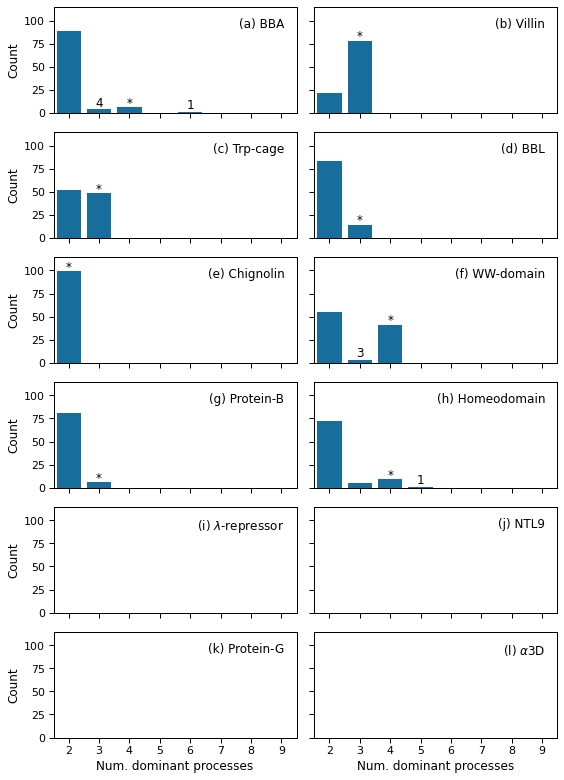

In [27]:


count_threshold = 1
gap_rank_threshold = 1.0
top_ts = ts_df.loc[ts_df['rank'] == gap_rank_threshold, :]

with sns.plotting_context('paper', font_scale=1.25):
    n_rows, n_cols = 6, 2
    sharey=True
    use_log = True # percentage change in timescale as gradient
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 11), sharex=True, sharey=sharey)

        
    ylabel = 'Count'
    xlabel = 'Num. dominant processes'
    
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]
            prot_ix = i*n_cols + j
            label = funcs.PROTEIN_LABELS[prot_ix]
            tmp = top_ts.loc[top_ts.protein==label, :]
            
            
            if tmp.shape[0]>1:
                sns.countplot(data=tmp, x='num_its',  order=np.arange(2, 10).astype(int), 
                                   color=funcs.cols[0], ax=ax)
                ax.set_ylabel(None)
                ax.set_xlabel(None)
                
                heights = [x.get_height() for x in ax.containers[0]]
                labels = [int(x) if x < 5 else '' for x in heights]
                ax.bar_label(ax.containers[0], labels)
                
                
            if sharey:
                if j == 0:
                    ax.set_ylabel(ylabel)
            else:
                ax.set_ylabel(ylabel)

            if i == n_rows - 1:
                ax.set_xlabel(xlabel)
            

            ax.annotate(text=f'({funcs.LETTERS[prot_ix]}) {label}', xy=(0.95, 0.9), 
                        xycoords='axes fraction', ha='right', va='top', 
                       bbox={'facecolor': 'w', 'alpha':0.8, 'edgecolor': 'w'})
            
            # annotate with the selected number
            gap_counts = tmp.groupby(['num_its'], as_index=False).count()
            gap_counts = gap_counts.loc[gap_counts['rank']>count_threshold, :]
            max_count = gap_counts['num_its'].max()
            if np.isfinite(max_count):
                max_count_x = max_count - 2
                ax.annotate(text=f"*", xy=(max_count_x, heights[max_count_x]), xytext=(0, 1), textcoords='offset points', ha='center')
            
            ax.set_ylim(0, 115)
    
    plt.tight_layout()
    plt.savefig(funcs.FIG_DIR.joinpath(f'num_dominant_processes_count.pdf'), bbox_inches='tight')

In [7]:
count_threshold = 1
gap_counts = top_ts.groupby(['protein', 'num_its'], as_index=False).count()
gap_counts = gap_counts.loc[gap_counts['rank']>count_threshold, :]
selected_num_dominant = gap_counts.groupby(['protein'], as_index=False)['num_its'].max()

selected_num_dominant['num_its'] = selected_num_dominant['num_its'].astype(int)

selected_num_dominant.to_hdf('chosen_num_dominant.h5', key='chosen_num_dominant')

In [8]:
# top_2_ts = ts_df.loc[ts_df['rank'] <=2, :]


# with sns.plotting_context('paper', font_scale=1.25):
#     n_rows, n_cols = 6, 2
#     sharey=True
#     use_log = True # percentage change in timescale as gradient
    
#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 11), sharex=True, sharey=sharey)

        
#     ylabel = 'Count'
#     xlabel = 'Num. dominant processes'
    
#     for i in range(n_rows):
#         for j in range(n_cols):
#             ax = axes[i, j]
#             prot_ix = i*n_cols + j
#             label = funcs.PROTEIN_LABELS[prot_ix]
#             tmp = top_2_ts.loc[top_2_ts.protein==label, :]
            
            
#             if tmp.shape[0]>1:
#                 sns.stripplot(data=tmp, x='num_its',y='grad_t',  hue='rank',  order=np.arange(2, 10).astype(int), 
#                                    color=funcs.cols[0], ax=ax, dodge=True)
#                 ax.set_ylabel(None)
#                 ax.set_xlabel(None)
                
# #                 heights = [x.get_height() for x in ax.containers[0]]
# #                 labels = [int(x) if x < 5 else '' for x in heights]
# #                 ax.bar_label(ax.containers[0], labels)
                
                
#             if sharey:
#                 if j == 0:
#                     ax.set_ylabel(ylabel)
#             else:
#                 ax.set_ylabel(ylabel)

#             if i == n_rows - 1:
#                 ax.set_xlabel(xlabel)
            

#             ax.annotate(text=f'({funcs.LETTERS[prot_ix]}) {label}', xy=(0.95, 0.9), 
#                         xycoords='axes fraction', ha='right', va='top', 
#                        bbox={'facecolor': 'w', 'alpha':0.8, 'edgecolor': 'w'})
    